## Imports

In [1]:
!nvidia-smi

Fri Jun  4 15:39:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install hub==1.3.5

In [3]:
import hub
from hub import Dataset, schema
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import img_as_ubyte
from glob import glob  
import tensorflow as tf
import random
import pandas as pd
from PIL import Image
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tqdm import tqdm

## Load Data from Hub

In [4]:
tag = "margauxmforsythe/cloud-segmentation-dataset"

# Load the data
print("Load data...")
ds = Dataset(tag)

Load data...


In [5]:
ds.meta

{'shape': [5155],
 'schema': {'type': 'SchemaDict',
  'items': {'image': {'shape': [384, 384, 4],
    'dtype': 'float64',
    'max_shape': [384, 384, 4],
    'chunks': None,
    'compressor': 'lz4',
    'type': 'Tensor'},
   'mask': {'shape': [384, 384, 1],
    'dtype': 'float64',
    'max_shape': [384, 384, 1],
    'chunks': None,
    'compressor': 'lz4',
    'type': 'Tensor'}}},
 'version': 1,
 'meta_info': {},
 'name': None,
 '.zarray': {'/image': {'chunks': [4, 384, 384, 4],
   'compressor': {'acceleration': 1, 'id': 'lz4'},
   'dtype': '<f8',
   'fill_value': 0.0,
   'filters': None,
   'order': 'C',
   'shape': [5155, 384, 384, 4],
   'zarr_format': 2},
  '/mask': {'chunks': [15, 384, 384, 1],
   'compressor': {'acceleration': 1, 'id': 'lz4'},
   'dtype': '<f8',
   'fill_value': 0.0,
   'filters': None,
   'order': 'C',
   'shape': [5155, 384, 384, 1],
   'zarr_format': 2}},
 '.hub.dynamic_tensor': {'/image': {'shape': [5155, 384, 384, 4]},
  '/mask': {'shape': [5155, 384, 384, 1

In [6]:
ds.meta['schema']['items']['image']['shape']

[384, 384, 4]

In [7]:
ds.meta['schema']['items']['mask']['shape']

[384, 384, 1]

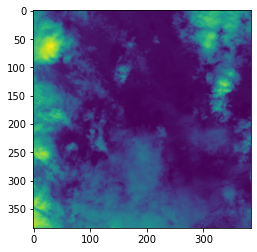

In [8]:
for i in range(len(ds)):  
  plt.imshow(ds["image"][i].compute()[:, :, 0])
  plt.show()
  break

## Hub dataset to Tensorflow Dataset

In [9]:
def to_model_fit(item):
    x = item["image"]
    # normalize
    x = x / tf.reduce_max(x)
    y = item["mask"] / 255 
    return (x, y)

# we choose to only use 1000 images for training because of GPU limit capacity 
image_count = len(ds[0:1000])
print(f"Images count: {image_count}") #Images count: 5155
ds_tf = ds[0:1000].to_tensorflow(include_shapes=True)
ds_tf = ds_tf.map(lambda x: to_model_fit(x))

Images count: 1000


(384, 384, 4)
(384, 384, 1)
[0. 1.]


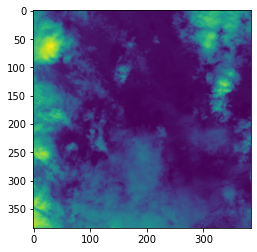

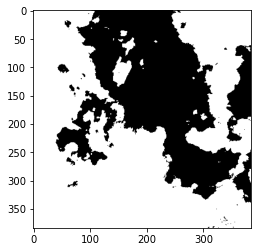

In [10]:
for img, label in ds_tf:
    print(img.shape)
    print(label.shape)
    print(np.unique(label))
    plt.imshow(img[:,:,0])
    plt.show()
    plt.imshow(label[:,:,0], cmap="gray")
    plt.show()
    break

In [11]:
train_size = int(0.8 * image_count)
val_size = int(0.1 * image_count)
test_size = int(0.1 * image_count)
batch_size = 16

ds_tf = ds_tf.shuffle(image_count)
test_ds = ds_tf.take(test_size)
train_ds = ds_tf.skip(test_size)
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

print(f"{train_size} training images, {val_size} validation images and {test_size} test images. Batch size of {batch_size}")

train_ds = train_ds.shuffle(train_size)
train_ds = train_ds.batch(batch_size)

val_ds = val_ds.shuffle(val_size)
val_ds = val_ds.batch(batch_size)

test_ds = test_ds.batch(1)

800 training images, 100 validation images and 100 test images. Batch size of 16


## Model definition

In [12]:
def unet(pretrained_weights=None, input_shape=(256, 256, 1), num_classes=12):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis=3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)

    # model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

## Training

In [13]:
model = unet(input_shape = (384,384,4))

In [14]:
if not os.path.isdir("./checkpoints"):
    print("Create folder checkpoints")
    os.mkdir("./checkpoints")

In [15]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('./checkpoints/weights.epoch-{epoch:02d}-val-iou-{val_iou:.4f}.hdf5',
                                                 monitor='val_iou', 
                                                 mode='max', verbose=1,
                                                 save_best_only=True,
                                                 save_weights_only=True)

In [16]:
# Compile the model and use some good metrics for segmentation
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy',
                  tf.keras.metrics.Recall(name="recall"),
                  tf.keras.metrics.Precision(name="precision"),
                  tf.keras.metrics.MeanIoU(num_classes=2, name='iou')])

In [17]:
model.fit(train_ds, 
          validation_data=val_ds, 
          epochs = 10,
          callbacks = [checkpoint_callback])

Epoch 1/10
     50/Unknown - 101s 2s/step - loss: 0.5931 - accuracy: 0.6600 - recall: 0.8716 - precision: 0.6131 - iou: 0.2494
Epoch 00001: val_iou improved from -inf to 0.25072, saving model to ./checkpoints/weights.epoch-01-val-iou-0.2507.hdf5
50/50 [==============================] - 155s 3s/step - loss: 0.5931 - accuracy: 0.6600 - recall: 0.8716 - precision: 0.6131 - iou: 0.2494 - val_loss: 0.5154 - val_accuracy: 0.7833 - val_recall: 0.9015 - val_precision: 0.7284 - val_iou: 0.2507
Epoch 2/10
49/50 [============================>.] - ETA: 1s - loss: 0.4594 - accuracy: 0.7847 - recall: 0.8168 - precision: 0.7625 - iou: 0.2540
Epoch 00002: val_iou did not improve from 0.25072
50/50 [==============================] - 129s 3s/step - loss: 0.4577 - accuracy: 0.7859 - recall: 0.8208 - precision: 0.7637 - iou: 0.2528 - val_loss: 0.4491 - val_accuracy: 0.8115 - val_recall: 0.9594 - val_precision: 0.7604 - val_iou: 0.2251
Epoch 3/10
49/50 [============================>.] - ETA: 1s - loss: 0.4

## Evaluation on test set

In [18]:
model.evaluate(test_ds)

    100/Unknown - 57s 569ms/step - loss: 0.2169 - accuracy: 0.9160 - recall: 0.9089 - precision: 0.9067 - iou: 0.2726

[0.21692454187199472, 0.9160077, 0.90885633, 0.9066985, 0.27258468]

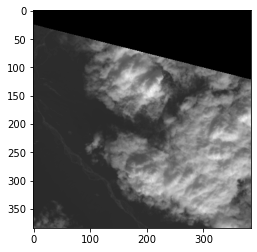

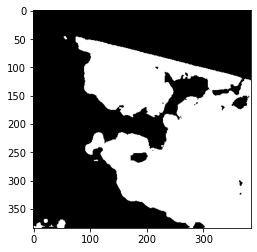

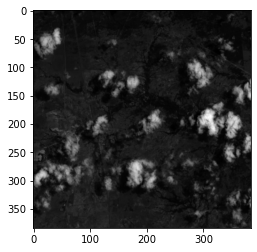

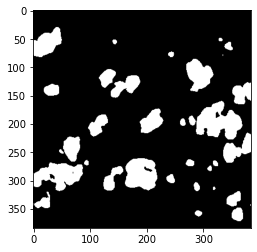

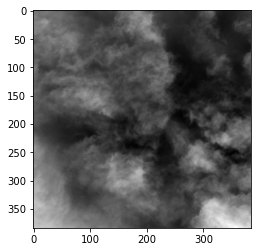

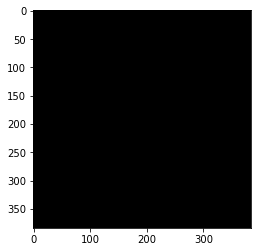

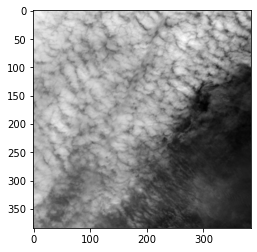

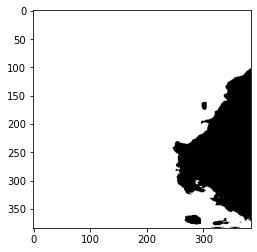

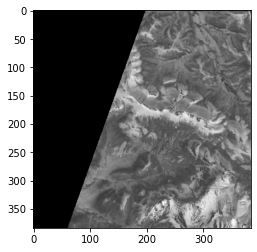

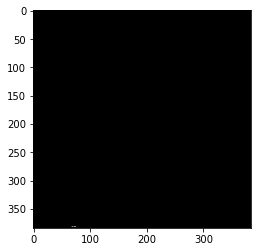

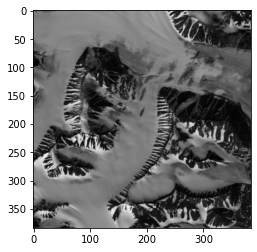

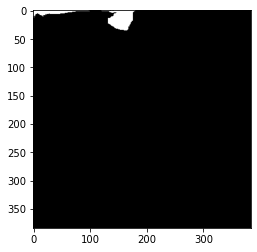

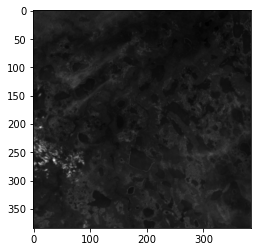

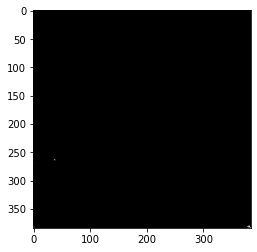

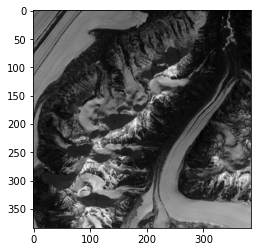

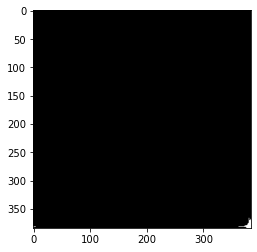

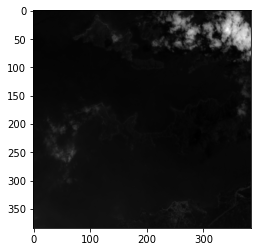

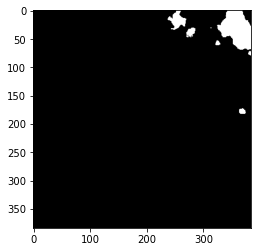

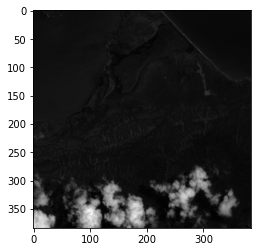

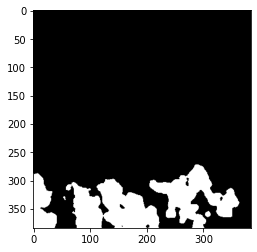

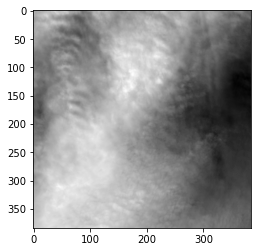

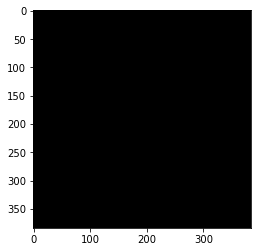

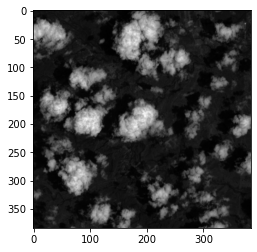

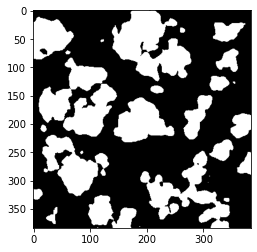

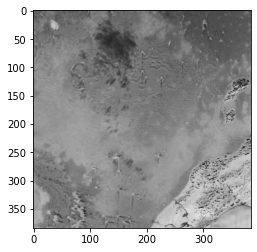

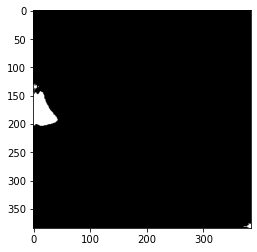

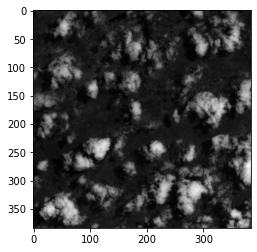

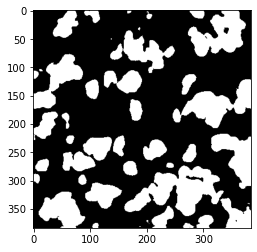

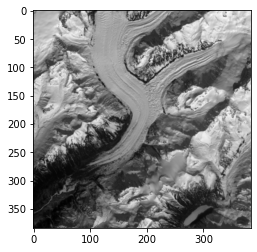

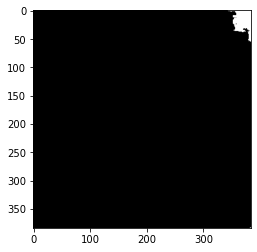

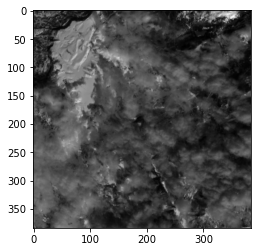

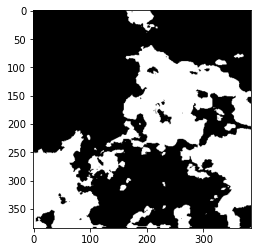

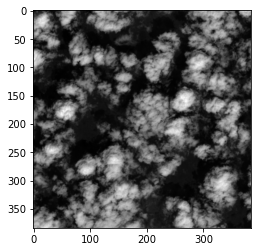

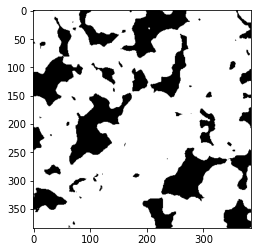

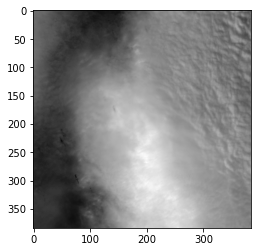

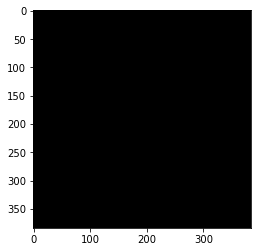

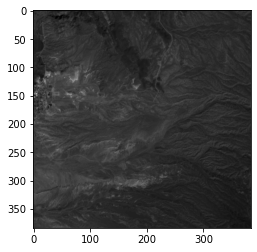

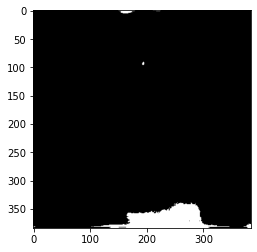

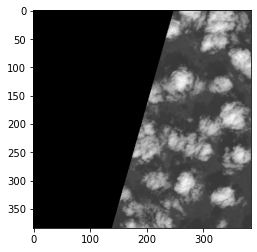

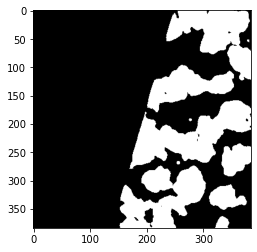

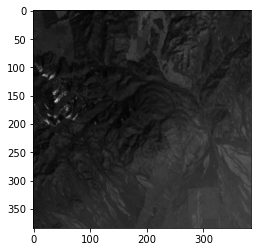

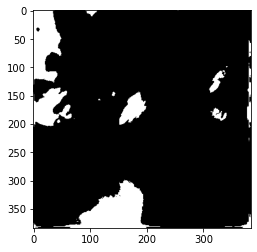

In [19]:
i = 0
model.load_weights('./checkpoints/weights.epoch-09-val-iou-0.2904.hdf5') # best weights
for img, label in test_ds:
  pred = (model.predict(img)[0] > 0.5).astype(np.uint8)
  plt.imshow(img[0][:,:,0], cmap="gray")
  plt.show()
  plt.imshow(pred, cmap="gray")
  plt.show()
  i = i + 1
  if i > 20:
    break